In [75]:
# Get everything setup for dedicated module loading

%load_ext autoreload
%autoreload 2
from renault.plot import plot_all_fluid, plot_fluids, plot_selective_fluid
from renault.get_data import get_most_important_types, get_pji_with_misssing_fluids_measure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [144]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans

import plotly.graph_objects as go
import plotly.express as px


# Imports and Loading data

In [4]:
COLUMN_NAMES = ['Unnamed: 0', 'siteCode', 
                'objectUAI', 'machine', 
                'fluid','measurement',
                'step', 'sourceTimestamp', 
                'pji', 'dataValue',
                'body_type', 'driving_side', 
                'gearbox_type', 'hybrid_level',
                'engine_type']

filling = ['ActVolume', 'ActMass']
STEPS = ['StepLoading', 'StepEndLoading']

## Cleaned data import

In [4]:
# Actual data import
df = pd.read_csv('../data/final_df_ropit.csv',index_col='Unnamed: 0')

# Removes 'UTC' in the timestape and convert to DT
time = [t[:19] for t in df.sourceTimestamp]
time = pd.to_datetime(time, infer_datetime_format=True)
df['time'] = time
df

/Users/alix/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time
0,FRFluid,ActVacuum,StepPumpPreVacuum,2021-05-11 07:01:00.565 UTC,911412,1,BJI,DG,BVM6,HYB01,H4D,2021-05-11 07:01:00
1,FRFluid,ActVacuum,StepPumpPreVacuum,2021-05-11 07:01:15.465 UTC,911412,1,BJI,DG,BVM6,HYB01,H4D,2021-05-11 07:01:15
2,RMFluid,ActVacuum,StepVacuum1,2021-05-11 07:01:18.971 UTC,911412,6,BJI,DG,BVM6,HYB01,H4D,2021-05-11 07:01:18
3,RMFluid,ActVacuum,StepVacuum1,2021-05-11 07:01:53.272 UTC,911412,63,BJI,DG,BVM6,HYB01,H4D,2021-05-11 07:01:53
4,RMFluid,ActVacuum,StepVacuum1,2021-05-11 07:01:53.865 UTC,911412,59,BJI,DG,BVM6,HYB01,H4D,2021-05-11 07:01:53
...,...,...,...,...,...,...,...,...,...,...,...,...
3036862,FRFluid,ActLoadingPressure,StepEndLoading,2021-05-26 23:58:18.197 UTC,2720139,479,BJI,DG,BVM6,HYB01,H4D,2021-05-26 23:58:18
3036863,FRFluid,ActLoadingPressure,StepEndLoading,2021-05-26 23:58:18.497 UTC,2720139,461,BJI,DG,BVM6,HYB01,H4D,2021-05-26 23:58:18
3036864,FRFluid,ActLoadingPressure,StepEndLoading,2021-05-26 23:58:18.593 UTC,2720139,458,BJI,DG,BVM6,HYB01,H4D,2021-05-26 23:58:18
3036865,FRFluid,ActLoadingPressure,StepEndLoading,2021-05-26 23:58:18.796 UTC,2720139,456,BJI,DG,BVM6,HYB01,H4D,2021-05-26 23:58:18


## Ananlysis of car types

In [5]:
vehicules = df.loc[:, ['pji', 'body_type','driving_side','gearbox_type','hybrid_level','engine_type']].drop_duplicates()

vehicules.iloc[:, 1:].describe()

,body_type,driving_side,gearbox_type,hybrid_level,engine_type
count,3599,3599,3599,3599,3599
unique,5,2,6,3,8
top,HJD,DG,BVM6,HYB01,H4D
freq,2327,3218,3084,3374,1955


**NOTE:** Percentage of production for the 10 most important models

Sum of this 10 model represent more than 90% of total production

In [6]:
top_cars = get_most_important_types(df, 10)
top_cars

,body_type,gearbox_type,engine_type,driving_side,hybrid_level,percentage_of_production
6,BJI,BVM6,H4D,DG,HYB01,23.011583
23,HJD,BVM6,K9K,DG,HYB01,21.389961
17,HJD,BVM6,H4D,DG,HYB01,14.851995
20,HJD,BVM6,H5H,DG,HYB01,6.280566
7,BJI,CVTX,H4D,DG,HYB01,4.427284
29,LJI,BVM6,H4D,DG,HYB01,4.015444
16,HJD,BVM6,H4D,DD,HYB01,3.963964
13,HJD,BVM5,H4M,DG,HYB01,3.449163
19,HJD,BVM6,H5H,DD,HYB01,2.651223
21,HJD,BVM6,K9K,DD,HYB01,2.342342


RMQ: The number of lines per vehicule appears to be ~ bimodal. One peak at ~100 and another at ~350

In [7]:
# Filter the data on the most representative type of vehicule
vehic_type = top_cars.iloc[0:1,:-1]

most_common_df = pd.merge(vehic_type, df, how='left',
         on= ['body_type','gearbox_type','engine_type','driving_side','hybrid_level'])
most_common_df = most_common_df[['fluid', 'measurement', 'step', 'pji', 'dataValue', 'time']]
most_common_df.head()

,fluid,measurement,step,pji,dataValue,time
0,FRFluid,ActVacuum,StepPumpPreVacuum,911412,1,2021-05-11 07:01:00
1,FRFluid,ActVacuum,StepPumpPreVacuum,911412,1,2021-05-11 07:01:15
2,RMFluid,ActVacuum,StepVacuum1,911412,6,2021-05-11 07:01:18
3,RMFluid,ActVacuum,StepVacuum1,911412,63,2021-05-11 07:01:53
4,RMFluid,ActVacuum,StepVacuum1,911412,59,2021-05-11 07:01:53


In [8]:
# add time-delta feature order by pji > fluid > measurement
most_common_df = most_common_df.sort_values(['fluid', 'measurement', 'time'])
delta = most_common_df.groupby(['pji', 'fluid', 'measurement'])['time'].diff()
delta = delta.fillna(pd.Timedelta(seconds=0))
delta = delta / np.timedelta64(1, 's')
most_common_df['delta'] = delta.values

In [9]:
most_common_df.head()

,fluid,measurement,step,pji,dataValue,time,delta
395,FRFluid,ActLoadingPressure,StepLoading,911412,464,2021-05-11 07:02:44,0.0
398,FRFluid,ActLoadingPressure,StepLoading,911412,158,2021-05-11 07:02:44,0.0
401,FRFluid,ActLoadingPressure,StepLoading,911412,164,2021-05-11 07:02:44,0.0
404,FRFluid,ActLoadingPressure,StepLoading,911412,162,2021-05-11 07:02:44,0.0
406,FRFluid,ActLoadingPressure,StepLoading,911412,163,2021-05-11 07:02:45,1.0


# KMeans clustering

In [170]:
rb = RobustScaler()
rb.fit(full_table)
X = rb.transform(full_table)

In [171]:
full_table.columns[full_table.isnull().sum() > 0]

MultiIndex([], names=[None, 'fluid', 'measurement'])

In [145]:
inertia =[]
for k in range(2, 21):
    cluster = KMeans(n_clusters=k)
    cluster.fit(X)
    inertia.append(cluster.inertia_)

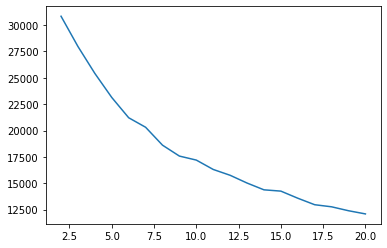

In [146]:
plt.plot(range(2, 21), inertia)

In [154]:
clu = KMeans(n_clusters=30).fit(X)

In [155]:
pd.Series(clu.predict(X)).value_counts()

2     89
29    83
27    80
19    76
12    73
23    65
22    60
26    50
0     47
7     41
11    40
17    35
15    33
20    17
14    16
9      5
6      5
13     2
8      1
24     1
16     1
4      1
5      1
18     1
21     1
3      1
10     1
28     1
1      1
25     1
dtype: int64

# T-SNE representation of anomalies

In [138]:
tsne = TSNE(n_components=2)
tsne.fit(X)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, n_jobs=None,
     perplexity=30.0, random_state=None, verbose=0)

In [139]:
deco = pd.DataFrame(tsne.fit_transform(X))
deco.columns = ['x', 'y']

In [140]:
deco['pji'] = final_df.index
deco['anomaly'] = [True if name in proximity.index else False for name in final_df.index]

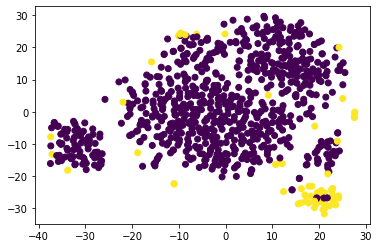

In [141]:
plt.scatter(deco.iloc[:,0], deco.iloc[:, 1], c=deco['anomaly'])

**PLOTLY GRAPHICS**

In [142]:

px.scatter(deco, x='x', y='y', color='anomaly', hover_name='pji')


# Feature engineering based on distribution

## Identify out of bonds pji base on last 10 dataValues

In [20]:
temp = most_common_df.groupby(['pji', 'fluid', 'measurement']).tail(10)
temp = temp.groupby(['pji', 'fluid', 'measurement'])['dataValue'].mean()
temp = temp.reset_index()
temp.head()

,pji,fluid,measurement,dataValue
0,220875,FRFluid,ActLoadingPressure,489.3
1,220875,FRFluid,ActVacuum,4.5
2,220875,FRFluid,ActVolume,89.5
3,220875,HFOFluid,ActLoadingPressure,1243.6
4,220875,HFOFluid,ActMass,425.8


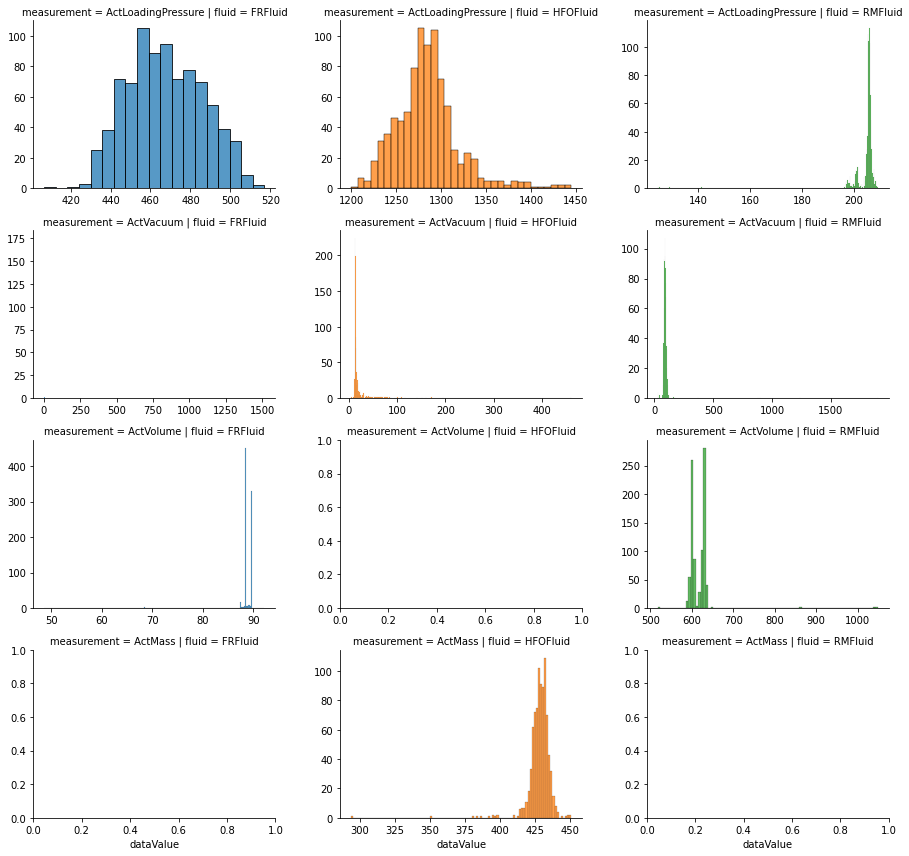

In [21]:
g = sns.FacetGrid(temp, col='fluid', row = 'measurement', hue='fluid',sharex=False, sharey=False)
g.map_dataframe(sns.histplot, 'dataValue')
g.fig.set_figwidth(13)

In [38]:
consign_values = temp.groupby(['fluid', 'measurement'])['dataValue'].describe(percentiles=[0.001, 0.999])
consign_values

count         mean        std     min       0.1%  \
fluid    measurement                                                            
FRFluid  ActLoadingPressure  854.0   467.450000  18.814924   406.9   421.4010   
         ActVacuum           870.0    15.671264  95.536052     2.9     3.4214   
         ActVolume           849.0    88.744994   1.862807    48.6    65.4752   
HFOFluid ActLoadingPressure  875.0  1284.590316  34.948257  1199.7  1207.0416   
         ActMass             874.0   428.221243   8.320038   294.0   343.9356   
         ActVacuum           882.0    20.570149  23.591779     4.9     6.1334   
RMFluid  ActLoadingPressure  876.0   204.767580   5.575561   124.5   125.0250   
         ActVacuum           884.0    96.024321  82.583829    28.5    29.3830   
         ActVolume           873.0   617.006186  26.952665   518.5   577.4472   

                                50%        99.9%          max  
fluid    measurement                                           
FRFluid  ActLoadingPressure   466.5   512.223200   517.000000  
         ActVacuum              5.7  1272.311000  1516.500000  
         ActVolume             88.5    90.758400    92.200000  
HFOFluid ActLoadingPressure  1282.8  1439.556000  1444.800000  
         ActMass              428.9   449.552400   450.600000  
         ActVacuum             14.2   226.682600   460.500000  
RMFluid  ActLoadingPressure   205.8   208.950000   209.300000  
         ActVacuum             90.1  1314.267833  1898.666667  
         ActVolume            620.7  1042.272800  1048.900000

Filtering based on quantile values

In [39]:
check_consign = pd.merge(temp, 
        consign_values[["0.1%", "99.9%"]].reset_index(),
        on=['fluid', 'measurement'],
        how='left')

In [41]:
filt = []
for i in check_consign.iterrows():
    filt.append(
        (i[1].dataValue < i[1]['0.1%']) |\
        ( i[1].dataValue > i[1]['99.9%'])
    )

Filtering based on deviation from mean and std

In [209]:
check_consign = pd.merge(temp, 
        consign_values[["mean", "std"]].reset_index(),
        on=['fluid', 'measurement'],
        how='left')

In [210]:
filt = []
for i in check_consign.iterrows():
    filt.append(
        (i[1].dataValue < i[1]['mean'] - i[1]['std']*4) |\
        ( i[1].dataValue > (i[1]['mean'] + i[1]['std']*4))
    )

In [42]:
#check_consign[filt][['pji', 'fluid', 'measurement']].groupby(['fluid', 'measurement'])['pji'].count()
check_consign[filt][['pji', 'fluid', 'measurement']]

,pji,fluid,measurement
271,630169,FRFluid,ActVolume
400,640096,FRFluid,ActVolume
444,640150,HFOFluid,ActLoadingPressure
1312,930928,FRFluid,ActLoadingPressure
1931,1031091,FRFluid,ActLoadingPressure
2151,1050767,RMFluid,ActVolume
2220,1111113,HFOFluid,ActVacuum
3165,1460498,HFOFluid,ActVacuum
4867,2131421,FRFluid,ActVacuum
5297,2230479,HFOFluid,ActLoadingPressure


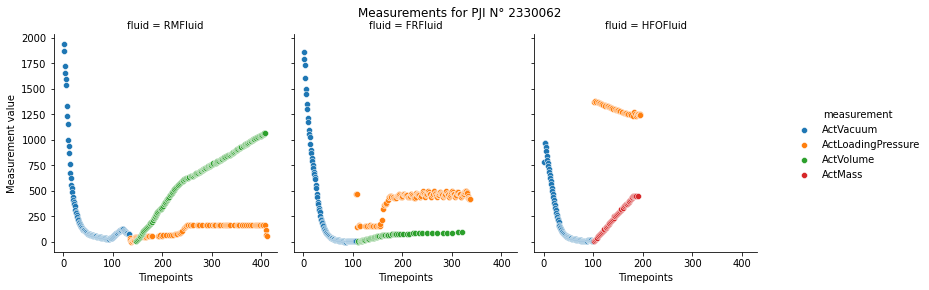

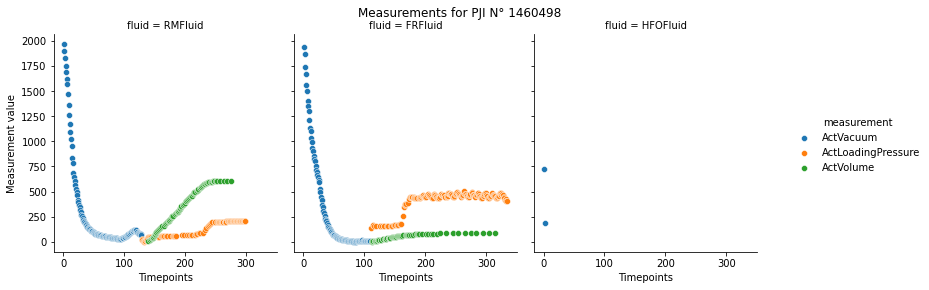

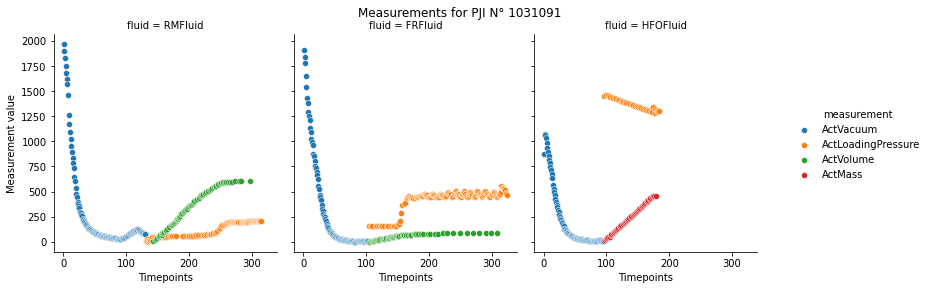

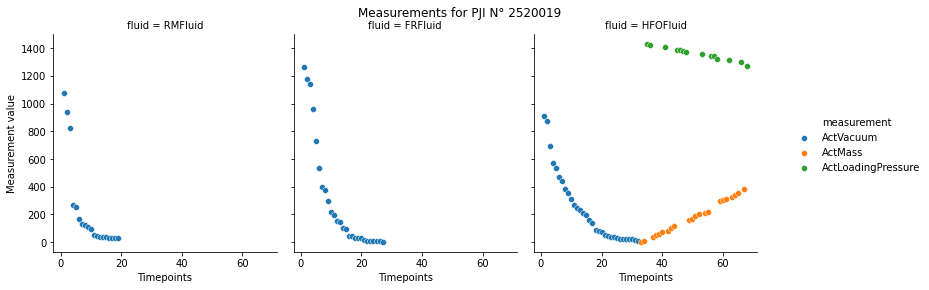

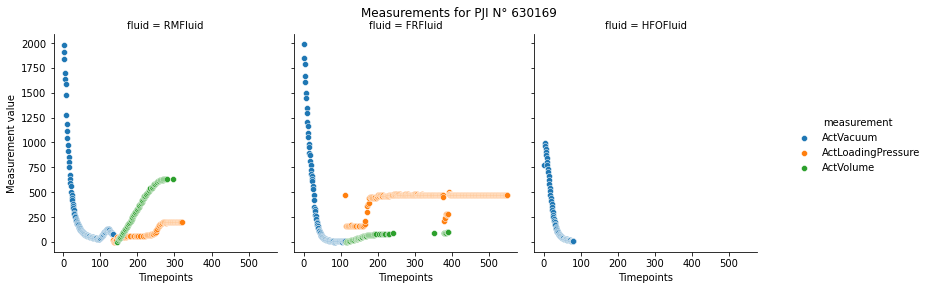

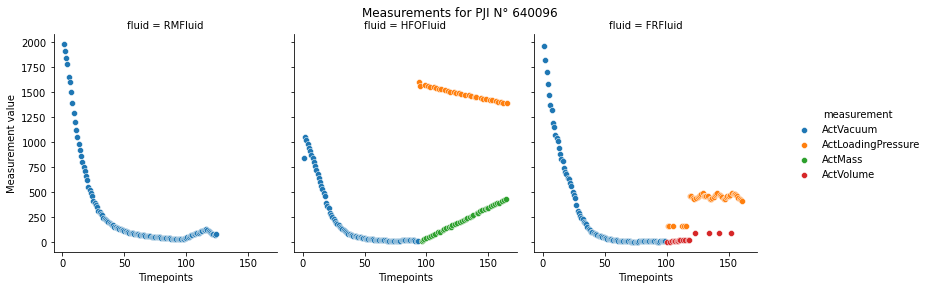

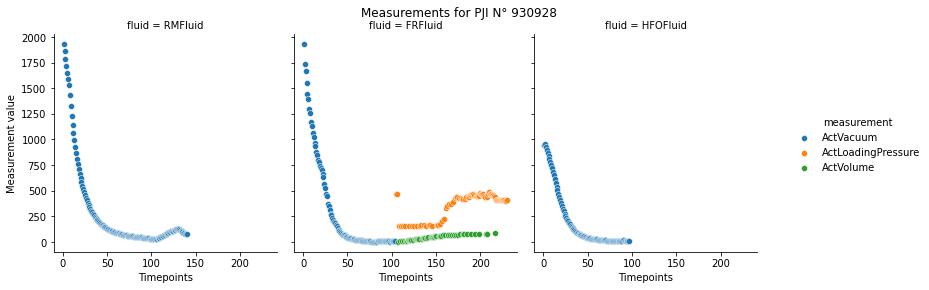

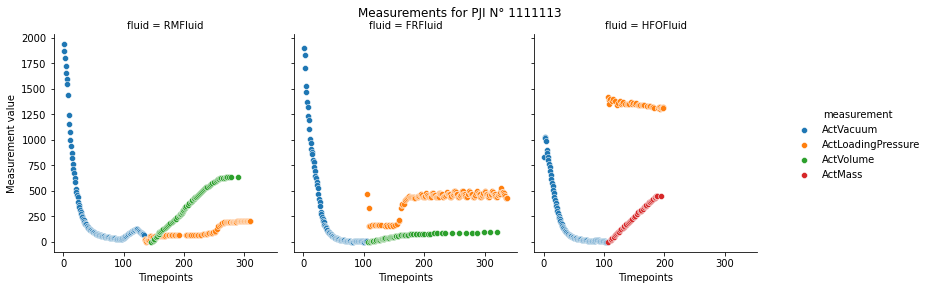

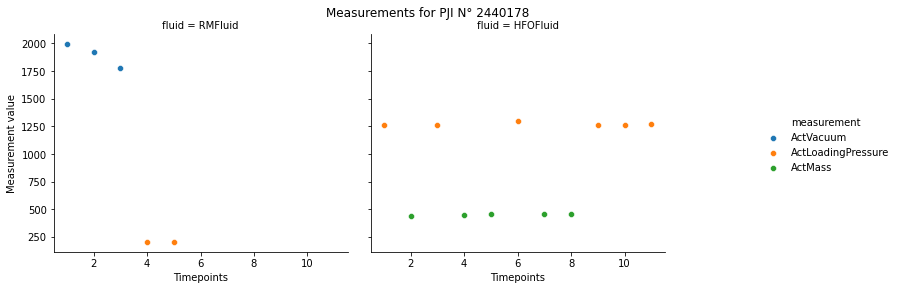

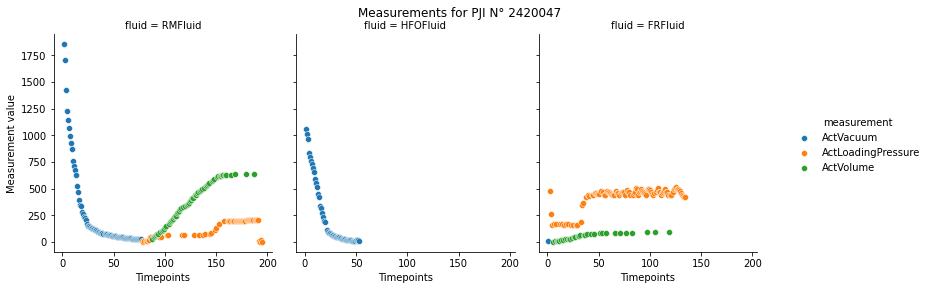

In [44]:
for pji in check_consign[filt]['pji'].sample(10).unique():
    plot_all_fluid(df, pji)

## Identify out of bonds pji base on dataValue slope

In [ ]:

most_common_df = most_common_df.sort_values(['fluid', 'measurement', 'time'])


#temp = most_common_df.groupby(['pji', 'fluid', 'measurement'])[data].tail(10)
slope = most_common_df.groupby(['pji', 'fluid', 'measurement'])['dataValue'].diff()
temp = most_common_df.copy()
temp['slope'] = slope
temp.head()

In [ ]:
temp = temp.groupby(['pji', 'fluid', 'measurement'])['slope'].describe()

temp = temp.reset_index()

In [ ]:
g = sns.FacetGrid(temp, col='fluid', row = 'measurement', hue='fluid',sharex=False, sharey=False)
g.map_dataframe(sns.histplot, 'min')
g.fig.set_figwidth(13)

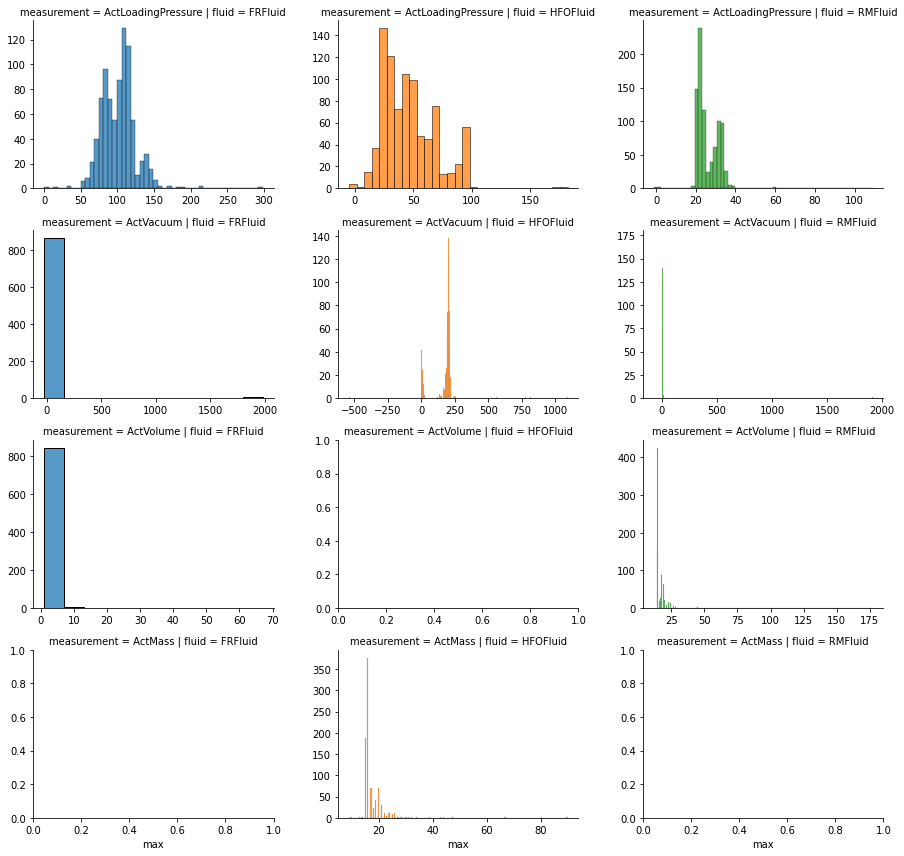

In [82]:
g = sns.FacetGrid(temp, col='fluid', row = 'measurement', hue='fluid',sharex=False, sharey=False)
g.map_dataframe(sns.histplot, 'max')
g.fig.set_figwidth(13)

In [ ]:
consign_values = temp.groupby(['fluid', 'measurement'])['max'].describe(percentiles=[0.01, 0.99])
consign_values

Filtering based on quantile values

In [ ]:
check_consign = pd.merge(temp, 
        consign_values[["1%", "99%"]].reset_index(),
        on=['fluid', 'measurement'],
        how='left')

filt = []
for i in check_consign.iterrows():
    filt.append(
        (i[1]['max'] < i[1]['1%']) |\
        ( i[1]['max'] > i[1]['99%'])
    )

Filtering based on deviation from mean and std

In [ ]:
check_consign = pd.merge(temp, 
        consign_values[["mean", "std"]].reset_index(),
        on=['fluid', 'measurement'],
        how='left')

filt = []
for i in check_consign.iterrows():
    filt.append(
        (i[1].dataValue < i[1]['mean'] - i[1]['std']*4) |\
        ( i[1].dataValue > (i[1]['mean'] + i[1]['std']*4))
    )

In [ ]:
#check_consign[filt][['pji', 'fluid', 'measurement']].groupby(['fluid', 'measurement'])['pji'].count()
check_consign[filt][['pji', 'fluid', 'measurement']]

In [ ]:
for pji in check_consign[filt]['pji'].sample(10).unique():
    plot_all_fluid(df, pji)

# KNN anomaly detection

In [10]:
# Global organisation of the data
# remove pji without 3 fluids and 3 measurements
bad_pji = get_pji_with_misssing_fluids_measure(most_common_df)
most_common_df = most_common_df[~most_common_df.pji.isin(bad_pji)]

# Observations are PJI
# columns are the differents features regrouped by fluids and measurements
# important features
# Average dataValue in tail(10)
mean_tail_value = most_common_df.groupby(['pji', 'fluid', 'measurement']).tail(10)
mean_tail_value = mean_tail_value.groupby(['pji', 'fluid', 'measurement'])[['dataValue']].mean()
#mean_tail_value = mean_tail_value.reset_index()
mean_tail_value

# Number of points in each group + average time delta
timing = most_common_df.groupby(['pji', 'fluid', 'measurement']).agg({'delta':['count', 'mean', 'max']})
timing

# Slope values (min max or q10, q90)
temp = most_common_df.copy()
temp = temp.sort_values(['fluid', 'measurement', 'time'])
slope = temp.groupby(['pji', 'fluid', 'measurement'])['dataValue'].diff()
temp = most_common_df.copy()
temp['slope'] = slope
temp = temp.groupby(['pji', 'fluid', 'measurement']).agg({'slope':["mean", "max"]})
#temp.reset_index(inplace=True)

temp

global_merged = pd.concat([mean_tail_value, timing, temp], axis=1, join='inner')
column_list = global_merged.columns
final_df = global_merged.pivot_table(values=column_list, 
                   index = ['pji'],
                   columns=['fluid', 'measurement'], sort=False )

final_df

In [128]:
pipe = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='constant', fill_value=-10)
)
pipe.fit(final_df)
X = pipe.transform(final_df)

In [133]:
near = NearestNeighbors(n_neighbors=10)
near.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

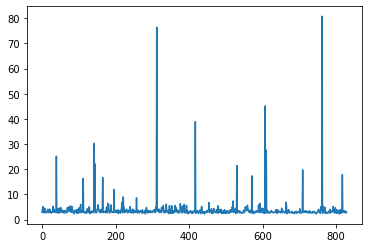

In [134]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = near.kneighbors(X)# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

In [135]:
# visually determine cutoff values > threshold
threshold = 5
outlier_index = np.where(distances.mean(axis = 1) > threshold)
outlier_index

(array([  2,  30,  39,  76,  81, 105, 112, 128, 142, 144, 152, 153, 165,
        176, 179, 180, 181, 188, 196, 217, 221, 239, 257, 310, 312, 328,
        330, 338, 346, 347, 353, 362, 376, 377, 382, 386, 387, 393, 417,
        434, 454, 479, 519, 520, 530, 553, 558, 559, 571, 589, 593, 607,
        610, 664, 665, 709, 758, 762, 764, 792, 816, 817]),)

In [136]:
proximity = pd.Series(distances.mean(axis =1))
proximity.index = final_df.index
proximity = proximity.sort_values(ascending=False)
proximity = proximity[proximity > threshold]
proximity

pji
2710108    80.807700
1330613    76.388374
2320061    45.175779
1650465    38.887827
931371     30.317114
             ...    
950084      5.124741
921358      5.110676
2620018     5.085053
2230478     5.077994
1011259     5.048394
Length: 62, dtype: float64

In [137]:
# filter outlier values
outlier_values = final_df.index[outlier_index]
outlier_values

Int64Index([ 460056,  630863,  640060,  740772,  750350,  910458,  911412,
             921358,  931371,  940444,  940637,  950084,  950487, 1011259,
            1011463, 1011466, 1011483, 1021333, 1030748, 1050753, 1050767,
            1121337, 1140456, 1330022, 1330613, 1460426, 1460448, 1511870,
            1521028, 1521062, 1531103, 1540963, 1611973, 1611977, 1612028,
            1620268, 1620271, 1621105, 1650465, 1660277, 1830813, 1930620,
            2151273, 2151275, 2160036, 2230421, 2230478, 2230479, 2250328,
            2310329, 2310638, 2320061, 2330062, 2420082, 2420084, 2440056,
            2620018, 2710108, 2710124, 2720058, 2730073, 2730079],
           dtype='int64', name='pji')

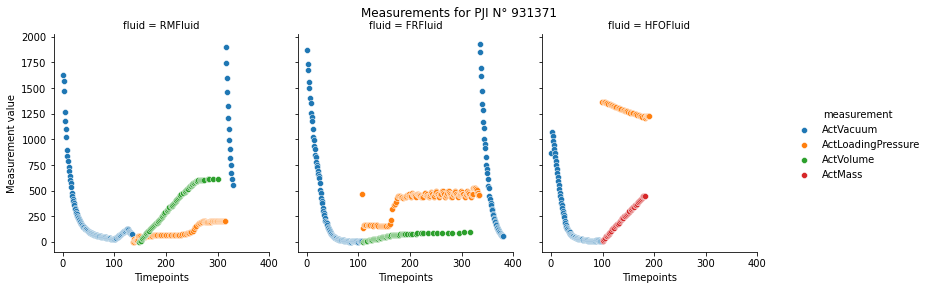

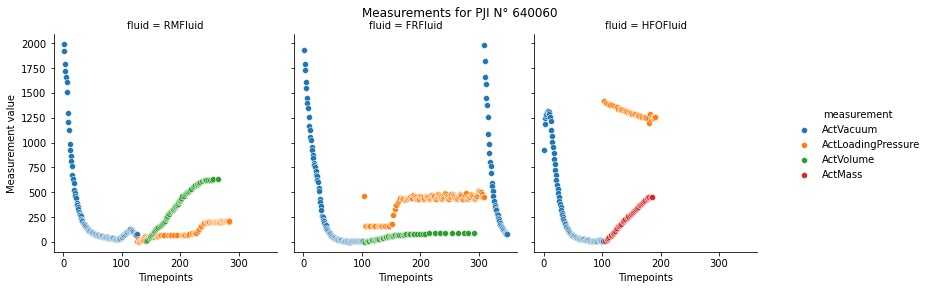

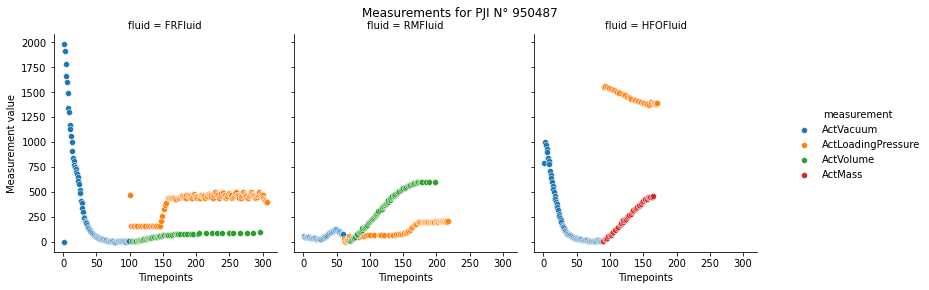

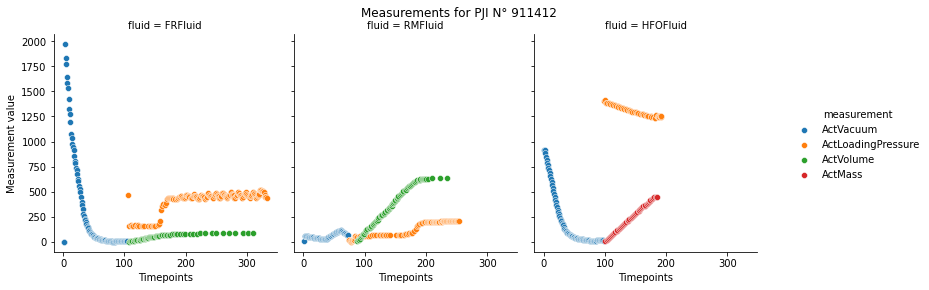

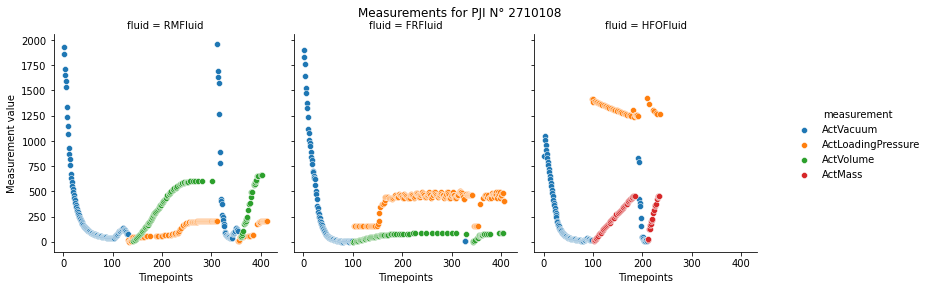

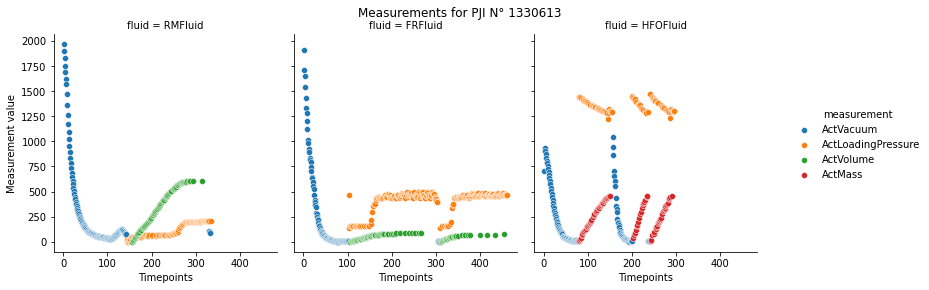

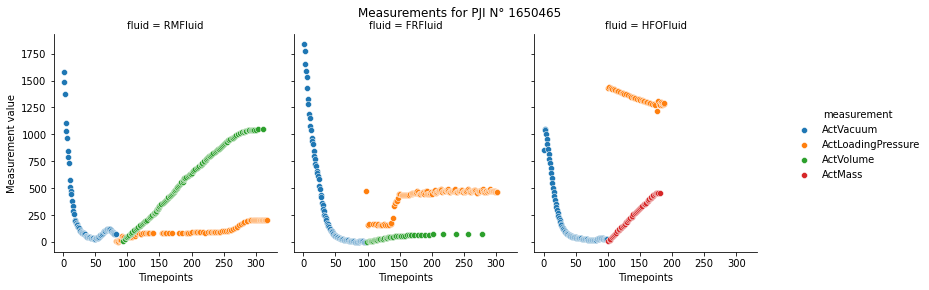

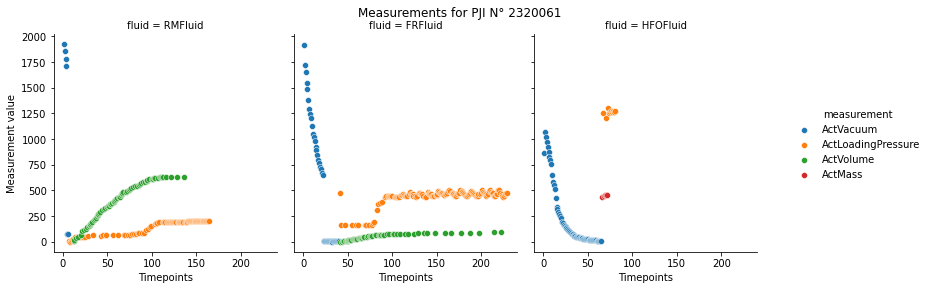

In [117]:
for pji in proximity.index:
    plot_all_fluid(df, pji)

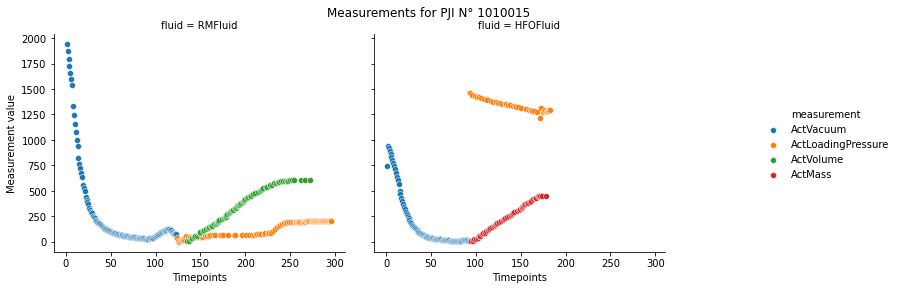

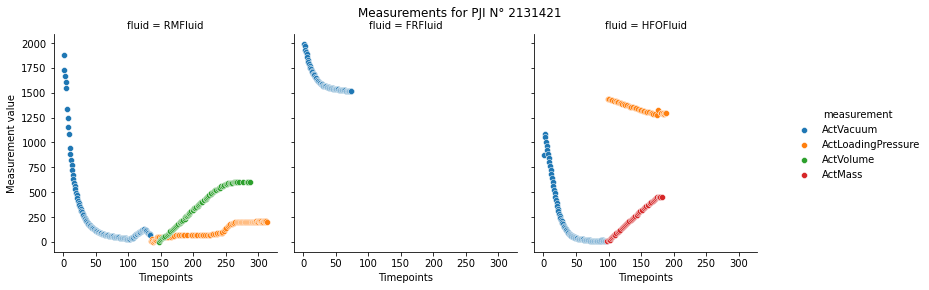

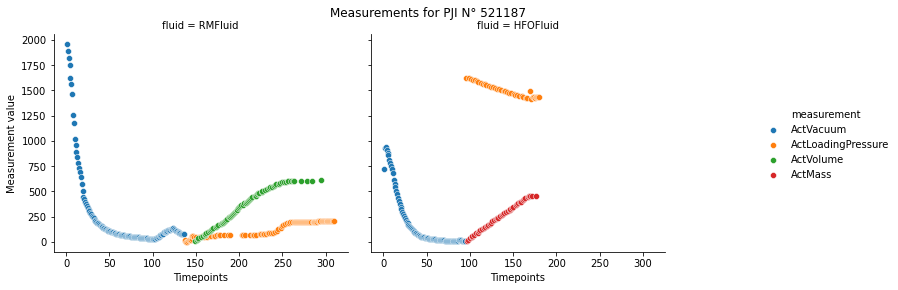

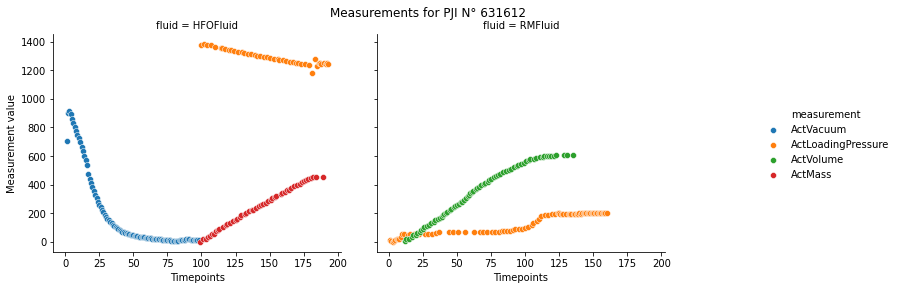

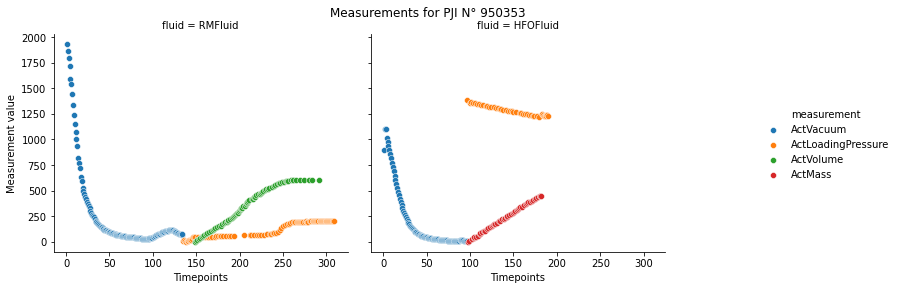

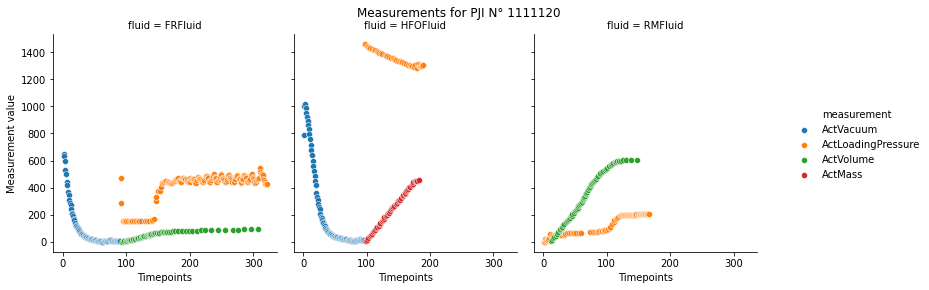

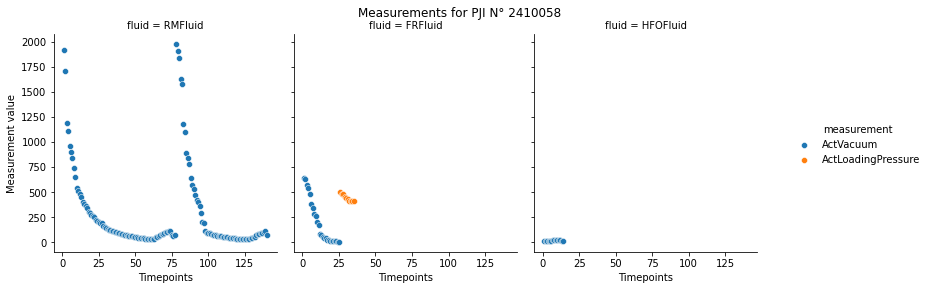

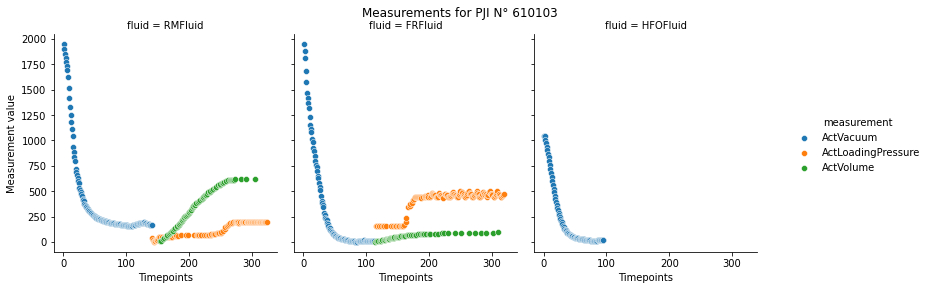

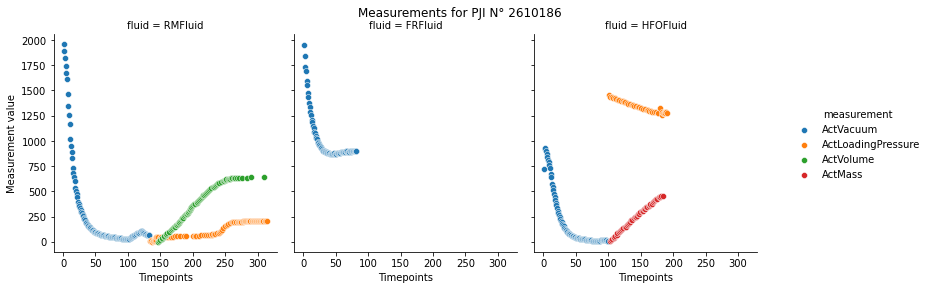

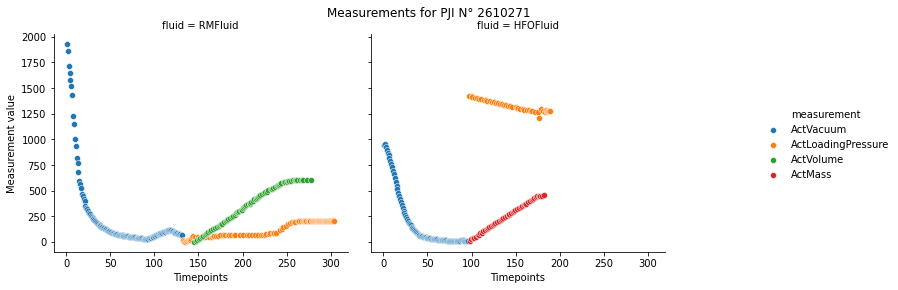

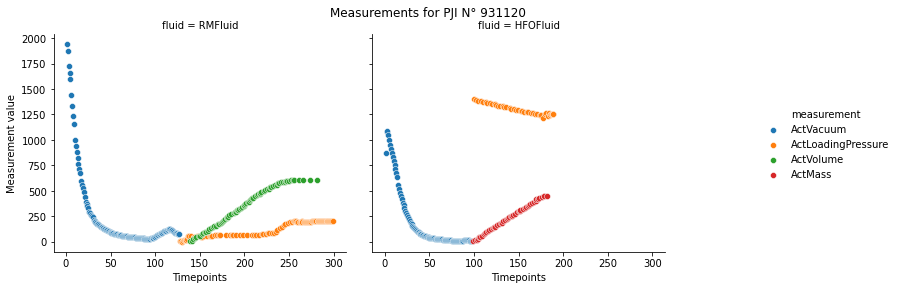

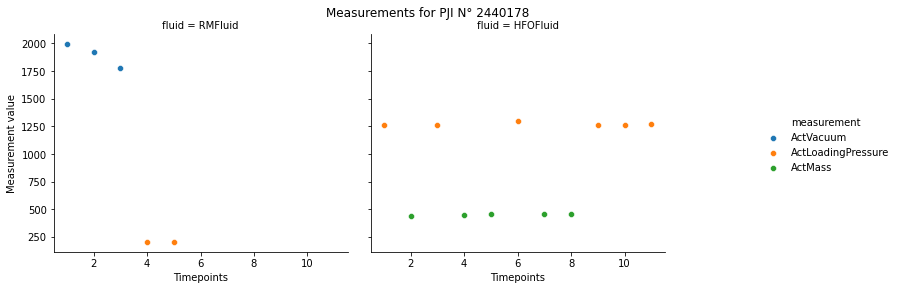

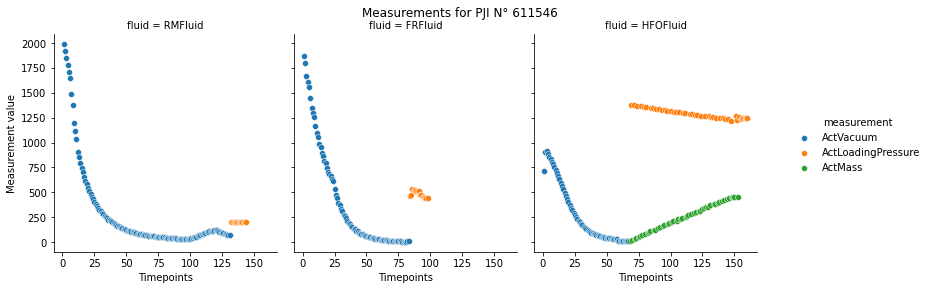

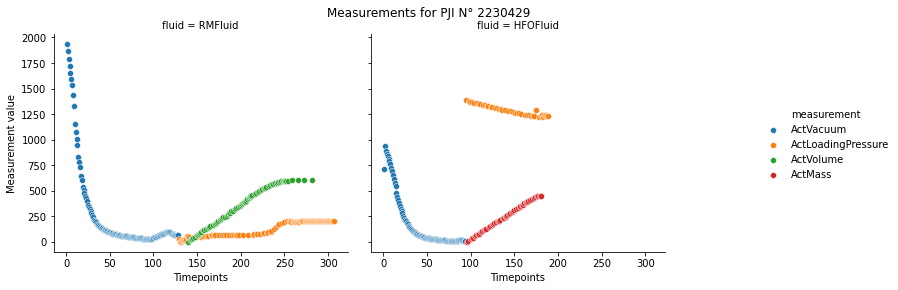

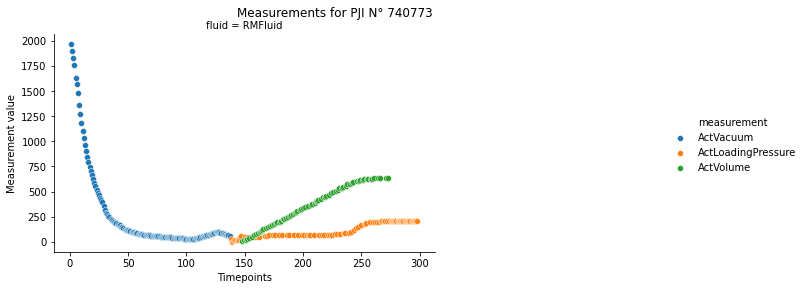

In [95]:
for name in pd.Series(bad_pji).sample(15):
    plot_all_fluid(df, name)